In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve, medfilt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib as mpl
from glob import glob
from copy import copy
from natsort import natsorted
from pandas import DataFrame


%matplotlib widget

In [2]:
# freqs, dark_s21 = np.load('./VNAsweep.npy')
freqs, dark_s21 = np.load('.\S21s_20241211_17h7\S21_dark.npy')
M_pxs = 32
N_pxs = 32

995


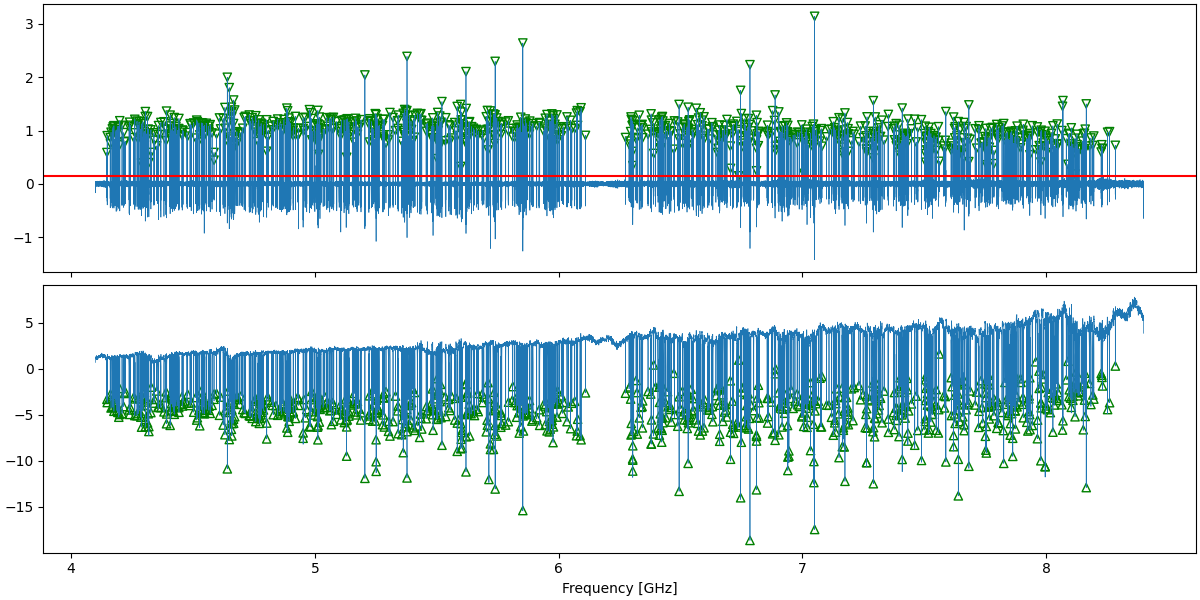

In [3]:
sw = 3 # even number
mph = 0.15
window = np.ones(sw)/sw
smooth_s21 = convolve(dark_s21, window, mode='same')
ds21 = np.diff(smooth_s21, 1)
smooth_ds21 = convolve(ds21, window, mode='same')
d2s21 = np.diff(smooth_ds21, 1)

locs, props = find_peaks(d2s21, height=mph, prominence=mph)
heights = props['peak_heights']

locs += 1
f0s = freqs[locs]
s21_mins = smooth_s21[locs]
fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
ax['a'].plot(freqs[:-2], d2s21, lw=.5)
ax['b'].plot(freqs, smooth_s21, lw=.5)
ax['a'].axhline(mph, c='r')

ax['a'].scatter(freqs[:-2][locs-1], heights, marker='v', c='None', edgecolor='g')
ax['b'].scatter(f0s, s21_mins, marker='^', c='None', edgecolor='g')
ax['b'].set_xlabel('Frequency [GHz]')
print(len(locs))

In [4]:
files = natsorted(glob('./S21s_20241211_17h7/*_*y0.npy'))
print(files)
nr_steps = len(files)
nr_kids = len(locs)
sweeps = np.empty((nr_steps, len(freqs)))
smoothed_sweeps = np.empty((nr_steps, len(freqs)))
s21s = np.empty((nr_steps, nr_kids))
s21s[:] = np.nan
smooth_dark_s21 = convolve(dark_s21, window, mode='same')
s0 = s21_mins
for i, file in enumerate(files):
    f, s21 = np.load(file)
    sweeps[i, :] = s21
    smooth_s21 = convolve(s21, window, mode='same')
    smoothed_sweeps[i, :] = smooth_s21
    s21s[i, :]  = smooth_s21[locs] - s0 

['./S21s_20241211_17h7\\S21_x1y0.npy', './S21s_20241211_17h7\\S21_x2y0.npy', './S21s_20241211_17h7\\S21_x3y0.npy', './S21s_20241211_17h7\\S21_x4y0.npy', './S21s_20241211_17h7\\S21_x5y0.npy', './S21s_20241211_17h7\\S21_x6y0.npy', './S21s_20241211_17h7\\S21_x7y0.npy', './S21s_20241211_17h7\\S21_x8y0.npy', './S21s_20241211_17h7\\S21_x9y0.npy', './S21s_20241211_17h7\\S21_x10y0.npy', './S21s_20241211_17h7\\S21_x11y0.npy', './S21s_20241211_17h7\\S21_x12y0.npy', './S21s_20241211_17h7\\S21_x13y0.npy', './S21s_20241211_17h7\\S21_x14y0.npy', './S21s_20241211_17h7\\S21_x15y0.npy', './S21s_20241211_17h7\\S21_x16y0.npy', './S21s_20241211_17h7\\S21_x17y0.npy', './S21s_20241211_17h7\\S21_x18y0.npy', './S21s_20241211_17h7\\S21_x19y0.npy', './S21s_20241211_17h7\\S21_x20y0.npy', './S21s_20241211_17h7\\S21_x21y0.npy', './S21s_20241211_17h7\\S21_x22y0.npy', './S21s_20241211_17h7\\S21_x23y0.npy', './S21s_20241211_17h7\\S21_x24y0.npy', './S21s_20241211_17h7\\S21_x25y0.npy', './S21s_20241211_17h7\\S21_x26y0.

In [5]:
sweeps_medfilt = medfilt(sweeps, kernel_size=3)

357


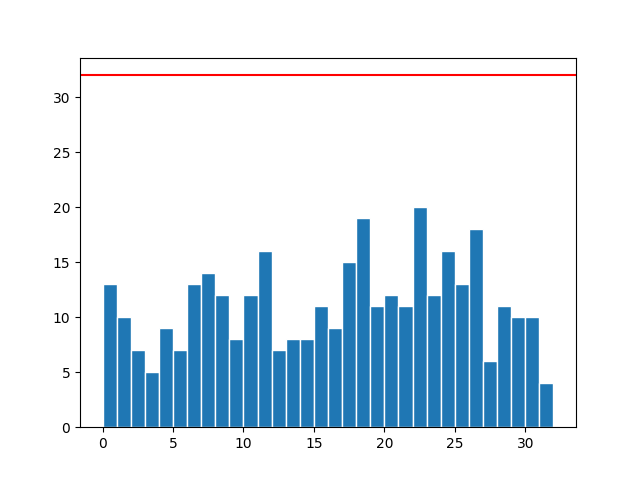

In [6]:
pos = np.empty((nr_kids,8)) # columns: meas idx, meas f0, x, y, design idx, design f0, design finger length, distance to centre
pos[:] = np.nan
pos[:, 0] = np.arange(nr_kids, dtype=int)
pos[:, 1] = f0s
for i in range(nr_kids):
    sweep = medfilt(s21s[:, i], 3)
    sweep_locs, sweep_props = find_peaks(sweep, prominence=.2)
    mask = np.ones(sweep.shape, dtype=bool)
    max_idx = np.nanargmax(sweep)
    max_sweep = sweep[max_idx]
    mask[max_idx] = 0
    std_sweep = np.std(sweep[mask])
    mean_sweep = np.mean(sweep[mask])
    threshold = mean_sweep + 4*std_sweep
    if len(sweep_locs) == 1:
        pos[i, 3] = max_idx
    # elif len(sweep_locs) > 1:
    #     print('more peaks', i)
    # else:
        # print('bad', i, len(sweep_locs))

    # if max_sweep > threshold:
    #     pos[i, 3] = max_idx
    #     if np.sum(sweep > threshold) > 1:
    #         print('second peak', i)
    #         print(len(sweep_locs))
    # else: 
    #     print('bad SNR', i)
    #     print(len(sweep_locs))
fig, ax = plt.subplots()
_ = ax.hist(pos[:, 3], bins=np.arange(nr_steps+1), facecolor='tab:blue', edgecolor='w')
ax.axhline(M_pxs, c='r')
print(np.sum(~np.isnan(pos[:, 3])))

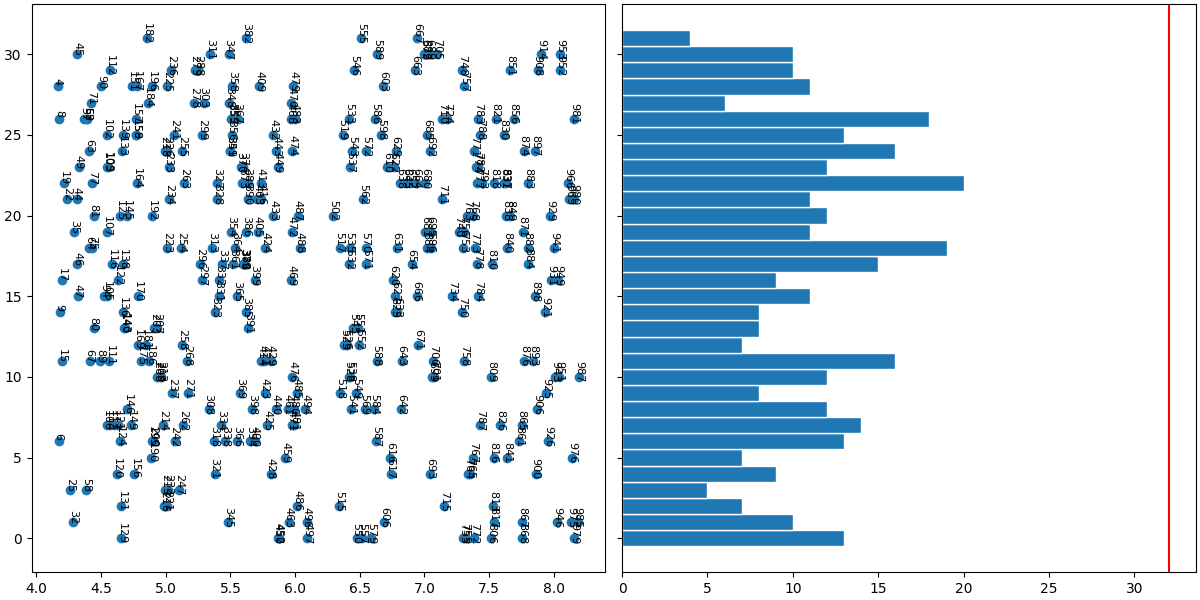

In [7]:
fig, ax = plt.subplot_mosaic('ab', figsize=(12, 6), constrained_layout=True, sharey=True)   
ax['a'].scatter(pos[:, 1], pos[:, 3], c='tab:blue')
for i, txt in enumerate(pos[:, 0]):
    ax['a'].annotate(int(txt), (pos[i, 1], pos[i, 3]+.3), fontsize=8, ha='center', va='center', rotation=-90)
ax['b'].hist(pos[:, 3], bins=np.arange(nr_steps+1)-.5, facecolor='tab:blue', edgecolor='w', orientation='horizontal')
ax['b'].axvline(M_pxs, c='r')


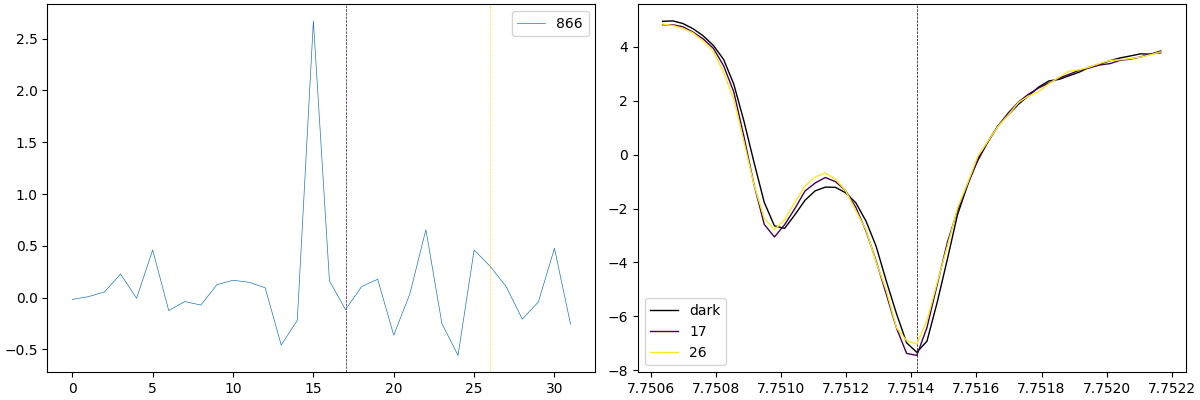

In [8]:
ids = np.arange(376, dtype=int)
ids = [866]
fig, ax = plt.subplot_mosaic('ba', figsize=(12, 4), constrained_layout=True)
start = 0
stop = 20
# steps = np.arange(start, stop)
steps = [17, 26]
bw = 25
colors = plt.cm.viridis(np.linspace(0, 1, len(steps)))
for id in ids:
    res = f0s[id]
    loc = locs[id]
    ax['a'].plot(freqs[loc-bw:loc+bw], smooth_dark_s21[loc-bw:loc+bw], lw=1, c='k', label='dark')
    ax['a'].axvline(res, c='k', ls='--', lw=.5)
    for i, step in enumerate(steps):
        ax['a'].plot(freqs[loc-bw:loc+bw], smoothed_sweeps[step, loc-bw:loc+bw], lw=1, label=str(step), c=colors[i])
        ax['b'].axvline(step, ls='--', lw=.5, c=colors[i])
    ax['b'].plot(s21s[:, id], lw=.5, label=str(id))
ax['b'].legend()
ax['a'].legend()

In [9]:
remove = [87, 969, 800, 867]
pos = np.delete(pos, remove, axis=0)

In [10]:
rows = [[] for _ in range(nr_steps)]
for i in pos:
    rows[int(i[3])].append(int(i[0]))
kids_derolled = np.empty((M_pxs, N_pxs))
kids_derolled[:] = np.nan   
for i, row in enumerate(rows):
    kids_derolled[i, :len(row)] = row
kids_derolled
nans = [[2, 21], [3, 30], [6, 9], [6, 19], [9, 8], [10, 26], [13, 25], [14, 11], [14, 31], [15, 17], [17, 13], [17, 14], [17, 21], [19, 31], [20, 13], [21, 8], [21, 18], [21, 28], [24, 12], [25, 13], [25, 18], [25, 29], [26, 31], [27, 2], [27, 12], [27, 22], [27, 23], [27, 30], [28, 20], [28, 23], [29, 25], [29, 30]]
for i, j in nans:
    kids_derolled[i, j+1:] = kids_derolled[i, j:-1]
    kids_derolled[i, j] = np.nan
kids_derolled
kids_derolled = np.flip(kids_derolled, axis=0)
fig, ax = plt.subplot_mosaic('a', figsize=(12, 6), constrained_layout=True, sharey=True)   
ax['a'].imshow(kids_derolled, cmap='viridis', origin='lower')
# for i, txt in enumerate(pos[:, 0]):
#     ax['a'].annotate(int(txt), (pos[i, 2], pos[i, 3]+.3), fontsize=8, ha='center', va='center', rotation=-90)


ValueError: cannot convert float NaN to integer

In [ ]:
kids = copy(kids_derolled)
for i, row in enumerate(kids_derolled):
    kids[i] = np.roll(row, i*11)
kids[~np.isnan(kids)] = kids[~np.isnan(kids)].astype(int)
kids
# kids[0:2] = np.nan
# kids[-2:] = np.nan
# kids[:, -1] = np.nan
fig, ax = plt.subplot_mosaic('a', figsize=(12, 6), constrained_layout=True, sharey=True)   
ax['a'].imshow(kids, cmap='viridis', origin='lower')

In [ ]:
kid_id_board = np.load('kid_id_board_32x32.npy').astype(int)
finger_length = np.load('.\LT361_4-8GHz_1024px_fingers.npy')
design_f0s = np.load('LT361_4-8GHz_1024px_F0s.npy')*1e-9
# design_f0s_original = np.load('LT361_FAB_F0s.npy')*1e-9
fig, ax = plt.subplot_mosaic('a', figsize=(12, 6), constrained_layout=True, sharey=True)   
ax['a'].imshow(kid_id_board, cmap='viridis', origin='lower')

In [ ]:
nanmask = np.isnan(kids)
design = design_f0s[kid_id_board[~nanmask]]
# original = design_f0s_original[kid_id_board[~nanmask]]
meas = f0s[kids[~nanmask].astype(int)]
df_f = (design-meas) / design
print(np.std(df_f))

In [ ]:
def linear(x, a, b):
    return a*x+b

def secorder(x, a, b, c):
    return a*x**2+b*x

line = linear
popt, pcov = curve_fit(line, design.flatten(), meas.flatten())
meas_fit = line(design, *popt)
df_f_corr = (meas - meas_fit) / meas_fit
df_fmap = np.empty((M_pxs, N_pxs))
df_fmap[:] = np.nan
count = 0
for i, row in enumerate(kids):
    for j, k in enumerate(row):
        if ~np.isnan(k):
            df_fmap[i, j] = df_f_corr[count]
            pos[pos[:, 0]==int(k), 2] = i
            count+=1
pos[:, 7] = np.sqrt((pos[:, 2]-(M_pxs-1)/2)**2+(pos[:, 3]-(N_pxs-1)/2)**2)
flim = np.array([np.min((design, meas)), np.max((design, meas))])

if line:
    if line == linear:
        eq = 'y=ax'
        save = 'fit_linear'
    elif line == secorder:
        eq = 'y=ax^2+bx'
        save = 'fit_secorder'
    print('line')
    popt, pcov = curve_fit(line, design.flatten(), meas.flatten())
    fit = line(design, *popt)
    xfit = np.linspace(flim[0], flim[1])
    yfit = line(xfit, *popt)
    label = 'y'
else:
    fit = design
    label = 'f_0^{design}'
    save = 'nofit'
size=32


fig, ax = plt.subplot_mosaic('abc', figsize=(16, 5), constrained_layout=True)
ax['a'].scatter(design, design, c='None', edgecolor='tab:blue', label='$\it f_0^{design}$')
ax['a'].scatter(design, meas, c='None', edgecolor='tab:orange', label='$\it f_0^{design}$')
# ax['a'].scatter(design, original, c='None', edgecolor='tab:gray', label='$\it f_0^{original}$')
if line:
    ax['a'].plot(xfit, yfit, c='k', label='fit: $%s$' % eq, ls='--', lw=0.5)
ax['a'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
ax['a'].set_ylabel('$\it f_0$ $[GHz]$')
ax['a'].set_xlim(flim)
ax['a'].set_ylim(flim)
ax['a'].legend(loc='upper left')
ax['b'].scatter(design, df_f_corr, c=df_f_corr, label='residual, $f_0-y_2$')
# for i, x in enumerate(design):
#     ax['b'].annotate(i, (x, df_f_corr[i]), fontsize=8, ha='center', va='center')
ax['b'].annotate
ax['b'].set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
ax['b'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
im = ax['c'].imshow(df_fmap, cmap='viridis', origin='lower')
for i, x in enumerate(df_fmap):
    for j, y in enumerate(x):
        if ~np.isnan(y):
            old_id = kid_id_board[i, j]
            new_id = kids[i, j]
            if old_id == new_id:
                c = 'w'
            else:
                c = 'r'
            # ax['c'].text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color=c)
# Major ticks
ax['c'].set_xticks(np.arange(0, size, 1))
ax['c'].set_yticks(np.arange(0, size, 1))
# Labels for major ticks
ax['c'].set_xticklabels(np.arange(1, size+1, 1))
ax['c'].set_yticklabels(np.arange(1, size+1, 1))
# labels
ax['c'].set_xlabel('$\it x$ $[px]$')
ax['c'].set_ylabel('$\it y$ $[px]$')
cbar = fig.colorbar(im, ax=ax['c'])
# cbar.ax.invert_yaxis()
_ = cbar.ax.set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
# _ = cbar.ax.set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
print(np.std(df_f_corr))
# fig, ax = plt.subplots()
# ax.scatter(pos[:, -1], df_f_corr[np.argsort(meas)])

In [ ]:
np.std(df_f_corr[np.absolute(df_f_corr)<0.01])

pos[pos[:, 0]==29]

In [ ]:
fig, ax = plt.subplots()


In [ ]:
fig, ax = plt.subplots()
ax.scatter(design, (meas-design)*1e3)

In [ ]:
nr_scans = s21s.shape[0]

def map():
    maps = np.zeros((M_pxs, N_pxs, nr_scans))
    for nr in range(nr_scans):
        for i, m in enumerate(kids):
            for j, k in enumerate(m):
                if ~np.isnan(k):
                    k = int(k)
                    s21s[:, k] -= np.amin(s21s[:, k])
                    s21s[:, k] /= np.amax(s21s[:, k])
                    maps[i, j, nr] = s21s[nr, int(k)]
                else:
                    maps[i, j, nr] = np.nan
    return maps

maps = map()


In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(maps[:, :, 0], origin='lower', cmap='viridis')
ax.set_xticks(np.arange(0, size, 1))
ax.set_yticks(np.arange(0, size, 1))
# Labels for major ticks
ax.set_xticklabels(np.arange(1, size+1, 1))
ax.set_yticklabels(np.arange(1, size+1, 1))

In [ ]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
cax = ax.imshow(maps[:, :, 0], origin='lower', cmap='viridis')
ax.set_xticks(np.arange(0, size, 1));
ax.set_yticks(np.arange(0, size, 1));
# Labels for major ticks
ax.set_xticklabels(np.arange(1, size+1, 1));
ax.set_yticklabels(np.arange(1, size+1, 1));

def update(frame):
    cax.set_array(maps[:, :, frame])
    return cax,
ani = animation.FuncAnimation(fig, update, frames=nr_scans, interval=200, blit=True)
plt.show()
ani.save('animation_chip9.gif', writer='Pillow')

In [ ]:
ids = np.arange(376, dtype=int)
ids = [23,78, 141, 567]
fig, ax = plt.subplot_mosaic('ba', figsize=(12, 4), constrained_layout=True)
start = 0
stop = 20
# steps = np.arange(start, stop)
steps = []
bw = 25
colors = plt.cm.viridis(np.linspace(0, 1, len(steps)))
for id in ids:
    res = f0s[id]
    loc = locs[id]
    ax['a'].plot(freqs[loc-bw:loc+bw], smooth_dark_s21[loc-bw:loc+bw], lw=1, c='k', label='dark')
    ax['a'].axvline(res, c='k', ls='--', lw=.5)
    for i, step in enumerate(steps):
        ax['a'].plot(freqs[loc-bw:loc+bw], smoothed_sweeps[step, loc-bw:loc+bw], lw=1, label=str(step), c=colors[i])
        ax['b'].axvline(step, ls='--', lw=.5, c=colors[i])
    ax['b'].plot(s21s[:, id], lw=.5, label=str(id))
ax['b'].legend()
ax['a'].legend()

In [ ]:
trims = np.load(r'C:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\mask-design\20x20_ebeam\LT361\LT361_20x20_4-8GHz_trimming\trim_array_edge_effect.npy')
# print(trims)
max_trim = (np.amax(trims[~np.isnan(trims)]))
print('max trim: %.2f' % max_trim)
trim_min = 4.5
finger_length = 111
nr_fingers = 7
max_cut = 104

kid_id_board = np.load('KID_ID_BOARD_20x20.npy').astype(int)
new_trims = copy(trims)
fingers = np.load(r'.\LT361_4-8GHz_400px_fingers.npy')
cuts = nr_fingers*finger_length - fingers 

idx2fingers = max_cut - (cuts[kid_id_board] % max_cut)<trims*1e-3
ids2fingers = kid_id_board[idx2fingers]
print('trims that span two fingers', ids2fingers)

idx2little = (cuts[kid_id_board] + trims*1e-3) % max_cut < trim_min
arg2little = np.argwhere(idx2little)
ids2little = kid_id_board[idx2little]
print('KIDs with trims less then trim minimum', ids2little)
# np.save('ids2little.npy', ids2little)
trims2little = trims[idx2little]*1e-3
print('corresopnding trims', trims2little)

In [ ]:
trim2 = int(np.amax(kids[trims==0 ]))
trim_from = trim2 + 1

fig, axes = plt.subplot_mosaic('abc', figsize=(8, 4), constrained_layout=True)
ax=axes['a']
design_fingers = fingers[kid_id_board[~nanmask]]
design_trims = trims[~np.isnan(kids)] * 1e-3
sort_idx = np.argsort(meas)
ax.scatter(design_fingers[sort_idx], design[sort_idx])
ax.scatter(design_fingers[sort_idx], meas[sort_idx])

def poly(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3+d*x**2+e*x+f

popt, pcov = curve_fit(poly, design_fingers[sort_idx], meas[sort_idx])
f_meas = poly(design_fingers[sort_idx], *popt)   
new_fingers = design_fingers[sort_idx]-design_trims[sort_idx]
f_trim = poly(new_fingers, *popt) - (f_meas - meas[sort_idx])
ax.plot(design_fingers[sort_idx], f_meas, c='tab:blue', ls='--', lw=1)	
ax.scatter(new_fingers, f_trim, c='None', edgecolors='tab:green')
ax = axes['b']
_ = ax.hist(meas[sort_idx][1:]-meas[sort_idx][:-1], bins='auto', facecolor='tab:orange', alpha=1)
_ = ax.hist(f_trim[1:trim_from]-f_trim[:trim2], bins='auto', facecolor='w',edgecolor='tab:orange', alpha=1)
_ = ax.hist(f_trim[trim2+2:]-f_trim[trim_from:-1], bins='auto', facecolor='w',edgecolor='tab:green', alpha=1)
ax = axes['c']
ax.scatter(meas[sort_idx][:trim_from], (f_trim- meas[sort_idx])[:trim_from], c='None', edgecolors='tab:orange') 
ax.scatter(meas[sort_idx][trim_from:], (f_trim- meas[sort_idx])[trim_from:], c='None', edgecolors='tab:green')
master_trim_array = np.stack((np.arange(len(f_trim)), pos[:, 4], meas[sort_idx], f_trim, design_trims[sort_idx], design_fingers[sort_idx]), axis=1)
master_trim_array[0]
np.save('master_trim_array.npy', master_trim_array)

In [ ]:
edgemask = np.zeros((M_pxs, N_pxs), dtype=bool)
edgemask[0] = 1
edgemask[:, -1] = 1
edgemask[:, 0] = 1
edgemask[-1] = 1
edge_f0s = f0s[kids[(edgemask) & (~nanmask)].astype(int)]
center_f0s = f0s[kids[(~edgemask) & (~nanmask)].astype(int)]
center_f0s.shape

In [351]:
center_ids = np.sort(kids[(~edgemask) & (~nanmask)].astype(int))
design_ids = np.sort(kid_id_board[~nanmask].astype(int))

In [352]:
sort_idx = np.argsort(center_f0s)
center_f0s = center_f0s[sort_idx]

In [ ]:
dfmin = 3e-3
dfmax = 10e-3
new_f0s = copy(f0s)
trimmed = 0 
for id in center_ids:
    f0 = f0s[id]
    if id == 0:
        new_f0s[id]  = f0
    else:
        prev_f0 = new_f0s[id-1]
        df = f0 - prev_f0
        if df < dfmin:
            new_f0s[id] = prev_f0 + dfmin
            trimmed += 1
print(trimmed)
fig, ax = plt.subplot_mosaic('ab')
ax['a'].scatter(edge_f0s, edge_f0s, label='edge', facecolor='tab:blue', edgecolor='w', alpha=1)   
ax['a'].scatter(center_f0s, center_f0s, label='center', facecolor='tab:green', edgecolor='None', lw=1, alpha=1)   
ax['a'].scatter(f0s, new_f0s, label='new center', facecolor='None', edgecolor='tab:red', lw=1, alpha=1)   
ax['a'].legend()
_ = ax['b'].hist(f0s[1:]-f0s[:-1], bins=np.arange(0, 0.1, 0.001), facecolor='tab:blue', edgecolor='w', alpha=.5)
_ = ax['b'].hist(new_f0s[1:]-new_f0s[:-1], bins=np.arange(0, 0.1, 0.001), facecolor='tab:orange', edgecolor='w', alpha=.5)

In [ ]:
dfmin = 7e-3
trimmed = 0 
f0s_untrim = f0s[:100]
f0s_trim = f0s[100:]
new_f0s = copy(f0s_trim)

for i, f0 in enumerate(f0s_trim):
    if i == 0:
        new_f0s[i]  = f0
    else:
        prev_f0 = new_f0s[i-1]
        df = f0 - prev_f0
        if df < dfmin:
            new_f0s[i] = prev_f0 + dfmin
            trimmed += 1
print(trimmed)
new_f0s = np.concatenate((f0s_untrim, new_f0s))
fig, ax = plt.subplot_mosaic('ab', figsize=(10, 4))
ax['a'].scatter(f0s, f0s-f0s, label='old', facecolor='tab:green', edgecolor='None', lw=1, alpha=1)   
ax['a'].scatter(f0s, new_f0s-f0s, label='new', facecolor='None', edgecolor='tab:red', lw=1, alpha=1)   
ax['a'].legend()
_ = ax['b'].hist(f0s[1:]-f0s[:-1], bins=np.arange(0, 0.1, 0.001), facecolor='tab:blue', edgecolor='w', alpha=.5)
_ = ax['b'].hist(new_f0s[1:]-new_f0s[:-1], bins=np.arange(0, 0.1, 0.001), facecolor='tab:orange', edgecolor='w', alpha=.5)

In [ ]:
def trim_func(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

x = pos[:, 2]
y = pos[:, 6]
popt, pcov = curve_fit(trim_func, x, y)

fig, ax = plt.subplot_mosaic('a', figsize=(6, 3), constrained_layout=True, sharex=True)
ax['a'].scatter(x, y, label='meas')
ax['a'].plot(x, trim_func(x, *popt), label='fit', c='tab:red')
new_fingers = trim_func(new_f0s, *popt)
ax['a'].scatter(new_f0s, new_fingers, label='new', c='tab:green')
ax['a'].legend()